# **USED CAR PRICE PREDICTION**

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Download file for plotting complexity curves

In [2]:
!curl https://raw.githubusercontent.com/francescopisu/Used-car-price-prediction/master/curves.py --output curves.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3760  100  3760    0     0  20434      0 --:--:-- --:--:-- --:--:-- 20434


### Downlod dataset

In [3]:
# May take up to 5 minutes depending on connection
!curl https://raw.githubusercontent.com/francescopisu/Used-car-price-prediction/master/data/cars.csv --output cars.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 86.2M  100 86.2M    0     0  45.0M      0  0:00:01  0:00:01 --:--:-- 45.0M


In [4]:
!pip install spark-sklearn
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 8.2 MB/s 
  Created wheel for spark-sklearn: filename=spark_sklearn-0.3.0-py3-none-any.whl size=30591 sha256=fbc71c69f255e0e61f1af97e1a7c9bd40217fefd7439fbbd266ae4428eac276c
  Stored in directory: /root/.cache/pip/wheels/7f/70/19/d106510bd662f519c7e89b40ca3c75c677eb7423cfe581f548
Successfully built spark-sklearn
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.19.2 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.19.2 wh

In [5]:
pip install rfpimp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10667 sha256=7ba39b8b7eb089832769d8540b921fcfc4edfcfd128acdd9fb1b057e0d41f951
  Stored in directory: /root/.cache/pip/wheels/ad/48/d9/21fc62fbeff405425b0d5dd8b0354576cdb62ac97f6b11d1ef
Successfully built rfpimp


**IMPORTING LIBRARIES**

In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import matplotlib
import numpy as np
import pickle
import matplotlib.pyplot as plt
import curves
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from spark_sklearn import GridSearchCV
from spark_sklearn.util import createLocalSparkSession
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify a

**READ THE CSV INPUT FILE**

In [7]:
# Read data
cars = pd.read_csv('cars.csv', encoding='latin1', error_bad_lines=False, warn_bad_lines=False)

In [8]:
cars.sample(5)

,Id,Price,Year,Mileage,City,State,Vin,Make,Model
255458,255459,18980,2011,66432,Los Angeles,CA,4JGBB5GB5BA680977,Mercedes-Benz,M-ClassRWD
815085,820452,15980,2014,45433,Urbana,IL,KM8JUCAG8EU847852,Hyundai,TucsonSE
161719,161720,29777,2014,15667,San Rafael,CA,WBA3N7C50EK221296,BMW,4
861531,866898,6495,2005,119202,Tucson,AZ,1J4GK38K85W526956,Jeep,LibertyRenegade
1163765,1180058,4900,2007,151728,Livermore,CA,JTDBT923771003946,Toyota,Yaris4dr


In [9]:
cars.columns

Index(['Id', 'Price', 'Year', 'Mileage', 'City', 'State', 'Vin', 'Make',
       'Model'],
      dtype='object')

## ANALYSING PRICE ATTRIBUTE

In [10]:
cars['Price'].describe()

count    1.216250e+06
mean     2.096887e+04
std      1.315940e+04
min      1.500000e+03
25%      1.299400e+04
50%      1.799500e+04
75%      2.641400e+04
max      4.995000e+05
Name: Price, dtype: float64

Skewness: 4.974661
Kurtosis: 80.585280


'\nWe can observe that the distribution of prices shows a high positive skewness \nto the left (skew > 1). A kurtosis value of 60 is extremely high, meaning that\nthere is a profusion of outliers in the dataset. We need to do something.\n'

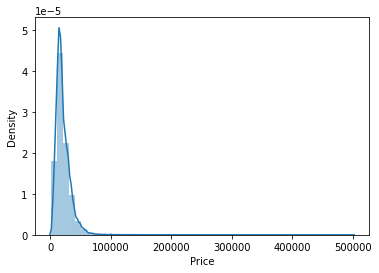

In [11]:
sns.distplot(cars['Price'])
#skewness and kurtosis
print("Skewness: %f" % cars['Price'].skew())
print("Kurtosis: %f" % cars['Price'].kurt())

"""
We can observe that the distribution of prices shows a high positive skewness 
to the left (skew > 1). A kurtosis value of 60 is extremely high, meaning that
there is a profusion of outliers in the dataset. We need to do something.
"""

### RELATIONSHIP WITH NUMERICAL FEATURES

"\nWe see that the lesser is the mileage, the higher tends to be the price. \nPrice and Mileage seem to be in an exponential relationship with negative\nexponent. It's a typical form of exponential decay.\n"

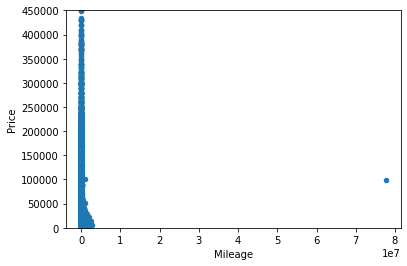

In [12]:
# Scatter plot Mileage / Price
attrib = 'Mileage'
data = pd.concat([cars['Price'], cars[attrib]], axis=1)
data.plot.scatter(x=attrib, y='Price', ylim=(0,450000));

"""
We see that the lesser is the mileage, the higher tends to be the price. 
Price and Mileage seem to be in an exponential relationship with negative
exponent. It's a typical form of exponential decay.
"""

'\nPrices tend to be higher as cars are more recent, and viceversa.\n'

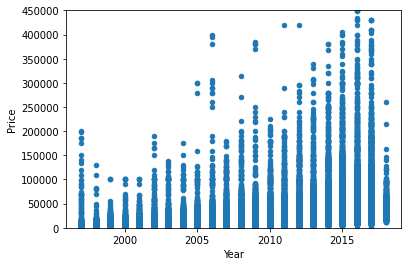

In [13]:
# Scatter plot Year / Price
attrib = 'Year'
data = pd.concat([cars['Price'], cars[attrib]], axis=1)
data.plot.scatter(x=attrib, y='Price', ylim=(0,450000));

"""
Prices tend to be higher as cars are more recent, and viceversa.
"""

### RELATIONSHIP WITH CATEGORICAL FEATURES

'\nWe can observe there is a correlation between Price and Exotic/Luxury car manufacturers.\nOn a sidenote, there is a prevalence of low to medium budget cars in the dataset\n\nSeveral car manufacturers as Porsche, Audi, Chevreolet ecc.. have a strong \npresence of outliers, altought outliers may not be the right term because\nthose makers produce car models that cost more than others.\n'

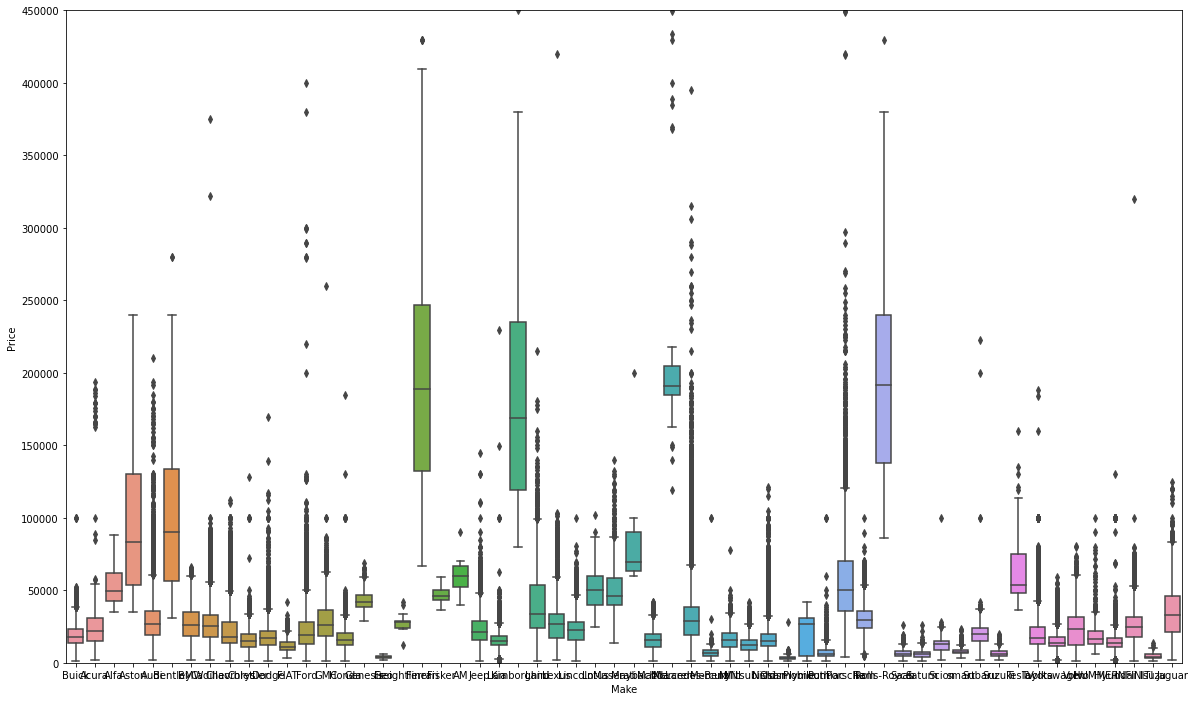

In [14]:
# Box plot Make (Car manufacturers) / Price

attrib = 'Make'
data = pd.concat([cars['Price'], cars[attrib]], axis=1)
f, ax = plt.subplots(figsize=(20, 12))
fig = sns.boxplot(x=attrib, y="Price", data=data)
fig.axis(ymin=0, ymax=450000);

"""
We can observe there is a correlation between Price and Exotic/Luxury car manufacturers.
On a sidenote, there is a prevalence of low to medium budget cars in the dataset

Several car manufacturers as Porsche, Audi, Chevreolet ecc.. have a strong 
presence of outliers, altought outliers may not be the right term because
those makers produce car models that cost more than others.
"""

In [ ]:
# Box plot Year / Price

attrib = 'Year'
data = pd.concat([cars['Price'], cars[attrib]], axis=1)
f, ax = plt.subplots(figsize=(18, 12))
fig = sns.boxplot(x=attrib, y="Price", data=data)
fig.axis(ymin=0, ymax=450000);

"""
We can observe a slight increase of Prices the most recent years. Not a strong
tendency though.
"""

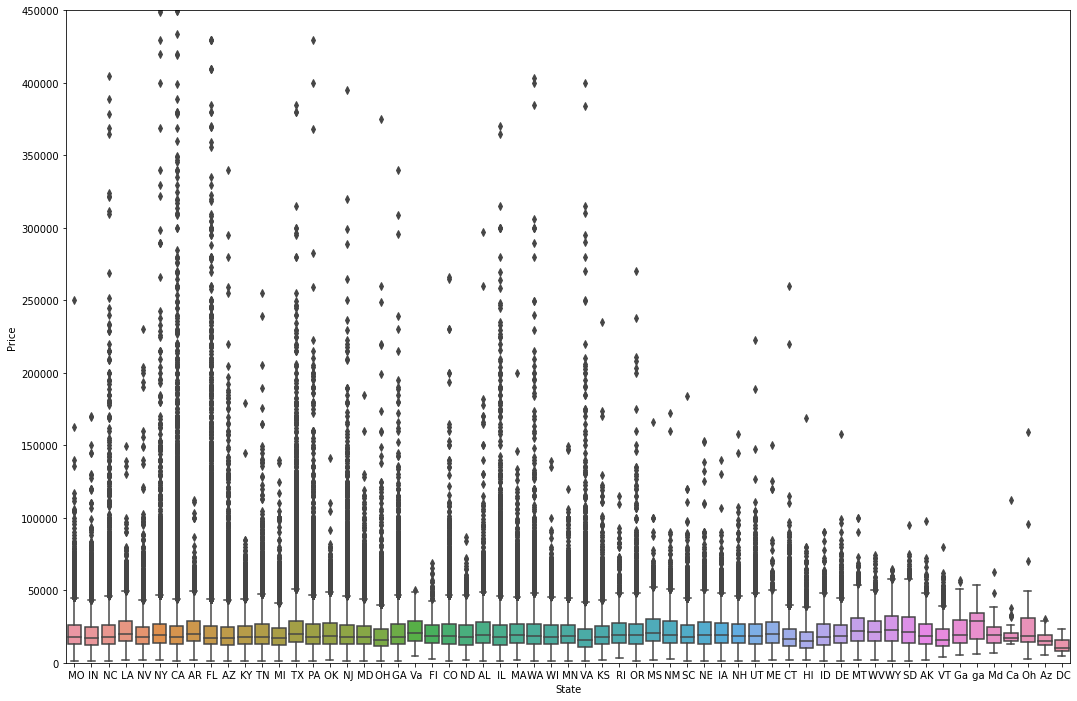

In [15]:
# Box plot State / Price

attrib = 'State'
data = pd.concat([cars['Price'], cars[attrib]], axis=1)
f, ax = plt.subplots(figsize=(18, 12))
fig = sns.boxplot(x=attrib, y="Price", data=data)
fig.axis(ymin=0, ymax=450000);

### FEATURE IMPORTANCE RELATED TO TARGET


In [16]:
# Find most important features relative to target Price
print("Find most important features relative to target")
corr = cars.corr()
corr.sort_values(["Price"], ascending = False, inplace = True)
print(corr.Price)

"""
Between Year and Price there is a positive correlation, meaning that the higher
is the Year (more recent), the higher is the Price (more recent cars cost more).
Between Price and Mileage there is a negative correlation, meaning that higher
is the mileage, lower is the Price (cars with high mileage cost less).

We obviously will get rid of Id attribute.
"""

Find most important features relative to target
Price      1.000000
Year       0.405673
Id        -0.013839
Mileage   -0.212439
Name: Price, dtype: float64


'\nBetween Year and Price there is a positive correlation, meaning that the higher\nis the Year (more recent), the higher is the Price (more recent cars cost more).\nBetween Price and Mileage there is a negative correlation, meaning that higher\nis the mileage, lower is the Price (cars with high mileage cost less).\n\nWe obviously will get rid of Id attribute.\n'

### CORRELATION MATRIX

'\nThere is a mild positive correlation between Year and Price and a mild\nnegative correlation between Year and Mileage (as we have already said).\nMoreover the is a strong negative correlation between Mileage and Year,\nmeaning that the older is the car, the higher will be its mileage.\nObviously there are exceptions but that is the general trend.\n'

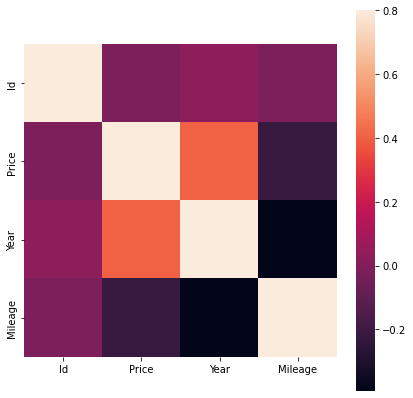

In [17]:
# General correlation matrix
corrmat = cars.corr()
f, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(corrmat, vmax=.8, square=True);

"""
There is a mild positive correlation between Year and Price and a mild
negative correlation between Year and Mileage (as we have already said).
Moreover the is a strong negative correlation between Mileage and Year,
meaning that the older is the car, the higher will be its mileage.
Obviously there are exceptions but that is the general trend.
"""

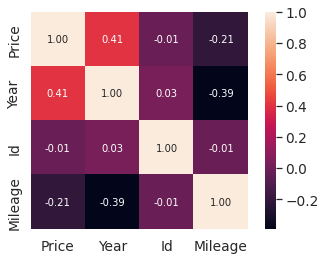

'\nThis plot shows what we said earies but in form of numbers.\n'

In [18]:
# Price correlation matrix
k = 4 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Price')['Price'].index
cm = np.corrcoef(cars[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

"""
This plot shows what we said earies but in form of numbers.
"""

### SCATTERPLOTS

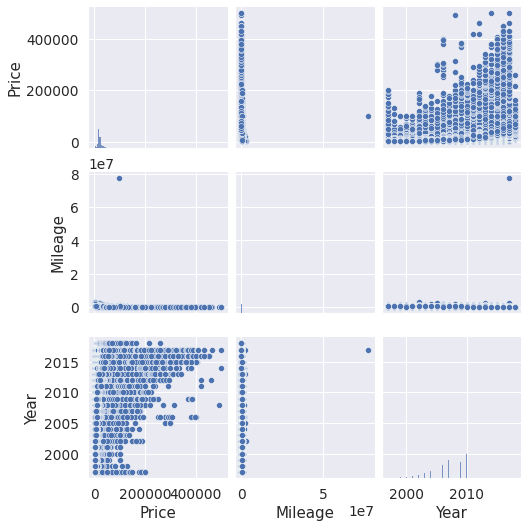

In [19]:
# Scatter plot for numerical features
num_features = ["Price", "Mileage", "Year"]
sns.pairplot(cars[num_features], size = 2.5)
plt.show();

## **PREPROCESSING**

In [20]:
# Checking for missing values -> no missing values
cars.isnull().sum()

Id         0
Price      0
Year       0
Mileage    0
City       0
State      0
Vin        0
Make       0
Model      0
dtype: int64

In [21]:
# Checking for plausible values of numerical features -> we can see that the maximum value of mileage is 77milion km
# we need to fix these problems
cars.describe()

,Id,Price,Year,Mileage
count,1.216250e+06,1.216250e+06,1.216250e+06,1.216250e+06
mean,6.132814e+05,2.096887e+04,2.013307e+03,5.290810e+04
std,3.546571e+05,1.315940e+04,3.441842e+00,8.192775e+04
min,1.000000e+00,1.500000e+03,1.997000e+03,5.000000e+00
25%,3.081122e+05,1.299400e+04,2.012000e+03,2.396200e+04
50%,6.134915e+05,1.799500e+04,2.014000e+03,4.053400e+04
75%,9.175538e+05,2.641400e+04,2.016000e+03,7.272500e+04
max,1.233042e+06,4.995000e+05,2.018000e+03,7.758776e+07


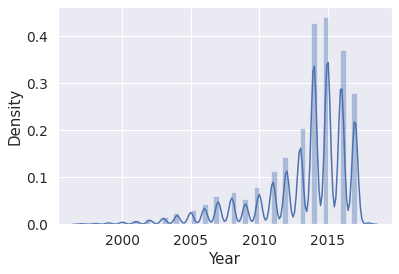

In [22]:
# Record distribution over the year
sns.distplot((cars["Year"]))

In [23]:
# Checking values of categorical features
cat_val = ["City", "State", "Vin", "Make","Model"]
for col in cat_val:
    print ([col]," : ",cars[col].unique())
    
# Features like Id, State and Vin can be discarded because wouldn't bring anything good to our purpose

['City']  :  ['Jefferson City' 'Highland' 'Boone' ... 'Northfield' 'Huntington Valley'
 'Winslow']
['State']  :  [' MO' ' IN' ' NC' ' LA' ' NV' ' NY' ' CA' ' AR' ' FL' ' AZ' ' KY' ' TN'
 ' MI' ' TX' ' PA' ' OK' ' NJ' ' MD' ' OH' ' GA' ' Va' ' Fl' ' CO' ' ND'
 ' AL' ' IL' ' MA' ' WA' ' WI' ' MN' ' VA' ' KS' ' RI' ' OR' ' MS' ' NM'
 ' SC' ' NE' ' IA' ' NH' ' UT' ' ME' ' CT' ' HI' ' ID' ' DE' ' MT' ' WV'
 ' WY' ' SD' ' AK' ' VT' ' Ga' ' ga' ' Md' ' Ca' ' Oh' ' Az' ' DC']
['Vin']  :  ['KL4CJBSBXFB267643' 'KL4CJASB5FB245057' 'KL4CJCSB0FB264921' ...
 'YV4A22PL4J1212676' 'YV4A22PL3H1186162' 'YV4A22NLXH1006162']
['Make']  :  ['Buick' 'Acura' 'Alfa' 'Aston' 'Audi' 'Bentley' 'BMW' 'Cadillac'
 'Chevrolet' 'Chrysler' 'Dodge' 'FIAT' 'Ford' 'GMC' 'Honda' 'Genesis'
 'Geo' 'Freightliner' 'Ferrari' 'Fisker' 'AM' 'Jeep' 'Kia' 'Lamborghini'
 'Land' 'Lexus' 'Lincoln' 'Lotus' 'Maserati' 'Maybach' 'Mazda' 'McLaren'
 'Mercedes-Benz' 'Mercury' 'MINI' 'Mitsubishi' 'Nissan' 'Oldsmobile'
 'Plymouth' 'Pontiac' 'P

### OUTLIERS MANAGEMENT

**BIVARIATE ANALYSIS**

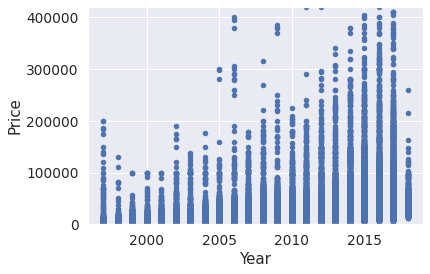

In [24]:
# Bivariate analysis Price / Year
attrib = 'Year'
data = pd.concat([cars['Price'], cars[attrib]], axis=1)
data.plot.scatter(x=attrib, y='Price', ylim=(0,420000));

**REMOVING OUTLIERS BY MODEL**

"\nWe can see a certain number of outliers. Now we'll try to get rid of those.\n"

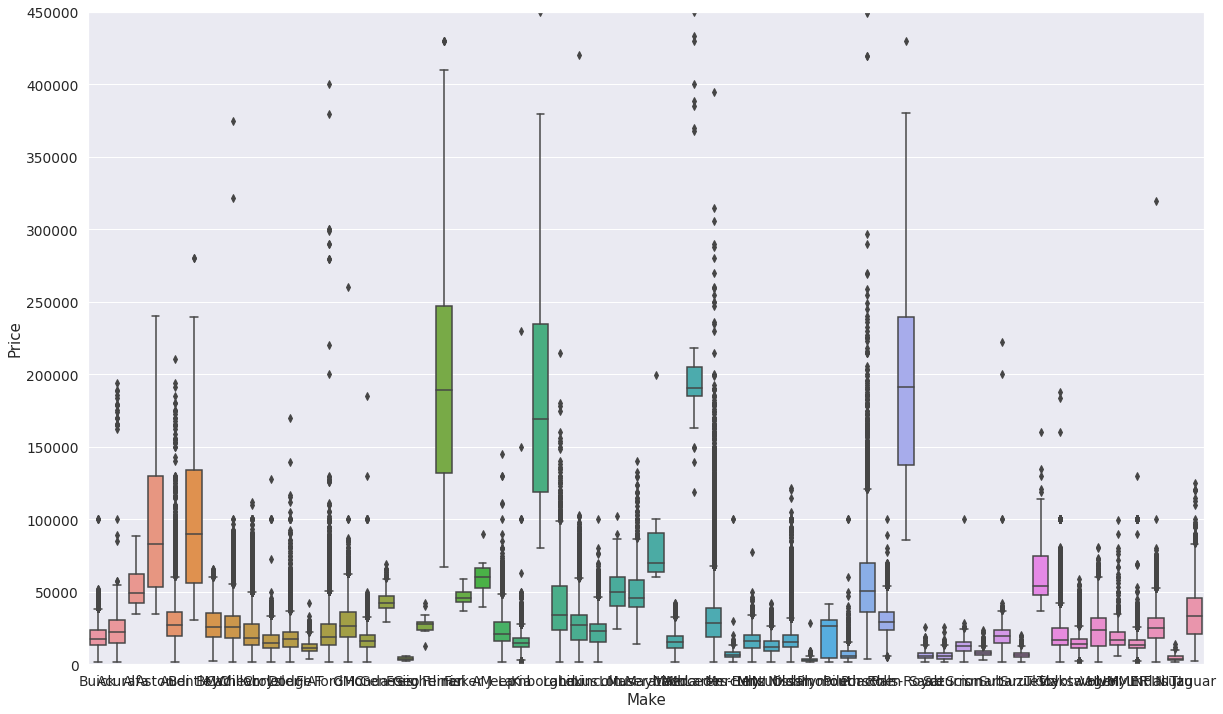

In [25]:
# Box Plot showing car manufacturer / Price range

attrib = 'Make'
data = pd.concat([cars['Price'], cars[attrib]], axis=1)
f, ax = plt.subplots(figsize=(20, 12))
fig = sns.boxplot(x=attrib, y="Price", data=data)
fig.axis(ymin=0, ymax=450000);

"""
We can see a certain number of outliers. Now we'll try to get rid of those.
"""

In [26]:
from numpy import percentile
from functools import partial

category='Model'

models = cars[category].unique()

"""
Here we are taking the values between the 25th and 80th percentile of the 
gaussian curve.
"""
p25 = cars.groupby(by=category)[category,'Price'].agg(lambda x: percentile(x['Price'], 20))
p80 = cars.groupby(by=category)[category,'Price'].agg(lambda x: percentile(x['Price'], 80))

KeyError: ignored

In [ ]:
# Now this strategy is applied to the 3k models; it will take up to 10 minutes
# depending on the hardware
models = cars[category].unique()

cars_cleaned = pd.DataFrame()

for i,m in enumerate(models):
    cars_cleaned=cars_cleaned.append(cars[( (cars[category] == m ) & ( (cars["Price"] > p25.Model[m]) & (cars["Price"] <= p80.Model[m])) ) ],ignore_index=True)


In [ ]:
cars_cleaned.to_csv('cars_outliers_removed.csv')

### ATTENTION
Alternatively, the cleaned_dataset can be downloaded executing the cell above:

In [27]:
!curl https://raw.githubusercontent.com/francescopisu/Used-car-price-prediction/master/data/cars_outliers_removed.csv --output cars_outliers_removed.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55.0M  100 55.0M    0     0  37.9M      0  0:00:01  0:00:01 --:--:-- 37.9M


In [28]:
# Reading the newly cleaned dataset
cleaned_cars = pd.read_csv("cars_outliers_removed.csv", encoding='latin1', error_bad_lines=False,warn_bad_lines=False)

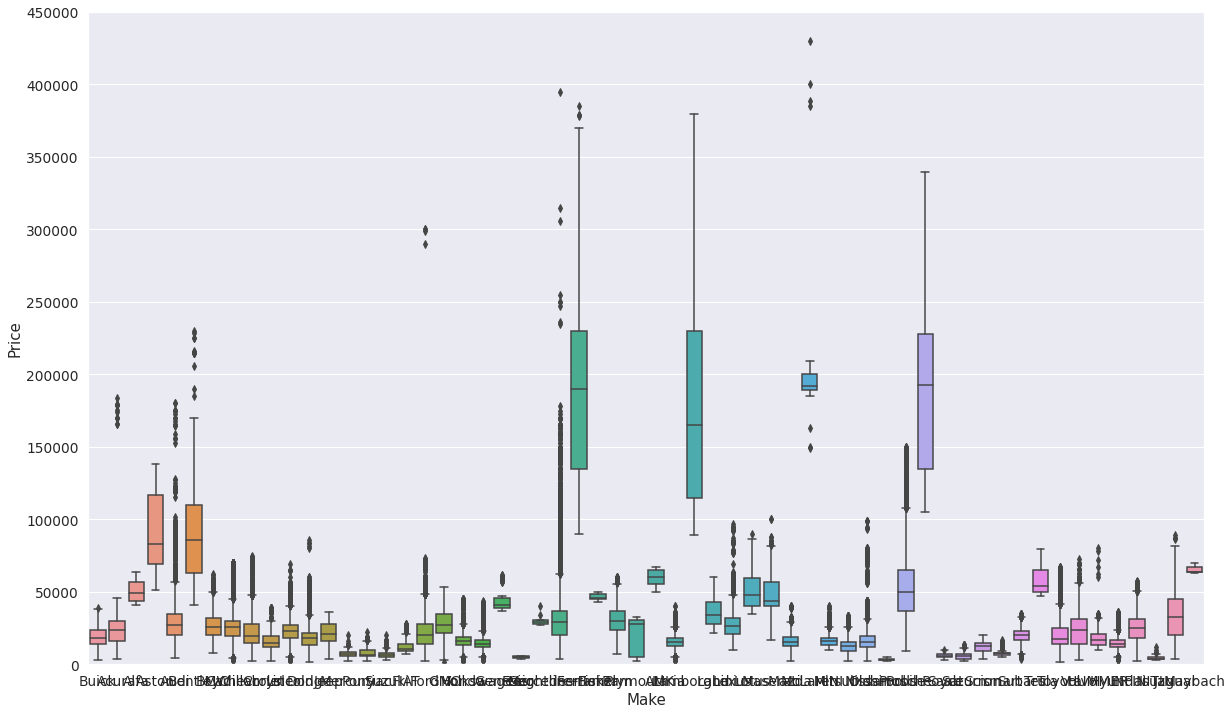

In [29]:
# Box Plot showing car manufacturer / Price range after cleaning

attrib = 'Make'
data = pd.concat([cleaned_cars['Price'], cleaned_cars[attrib]], axis=1)
f, ax = plt.subplots(figsize=(20, 12))
fig = sns.boxplot(x=attrib, y="Price", data=data)
fig.axis(ymin=0, ymax=450000);

In [31]:
print("Too new: %d" % cleaned_cars.loc[cleaned_cars.Year >= 2017].count()['Id'])
print("Too few km: " , cleaned_cars.loc[cleaned_cars.Mileage < 5000].count()['Id'])
print("Too many km: " , cleaned_cars.loc[cleaned_cars.Mileage > 250000].count()['Id'])

Too new: 71946
Too few km:  14055
Too many km:  374


In [32]:
# Drop some unuseful columns with respect to our analysis
cleaned_cars = cleaned_cars.drop(["Id", "State", "Vin", "City"], axis=1)

# Replace the NaN values for categoric attributes
cleaned_cars['Make'].fillna(value='blank', inplace=True)
cleaned_cars['Model'].fillna(value='blank', inplace=True)


# Drop duplicates
cleaned_cars = cleaned_cars.drop_duplicates(["Year", "Mileage", "Price", "Make", "Model"])

# Remove outliers
cleaned_cars = cleaned_cars[
        (cleaned_cars.Year <= 2017) 
      & (cleaned_cars.Year >= 2008)  
      & (cleaned_cars.Mileage >= 5000) 
      & (cleaned_cars.Mileage <= 250000)]

# Remove extra column
cleaned_cars = cleaned_cars.drop(["Unnamed: 0"], axis=1)

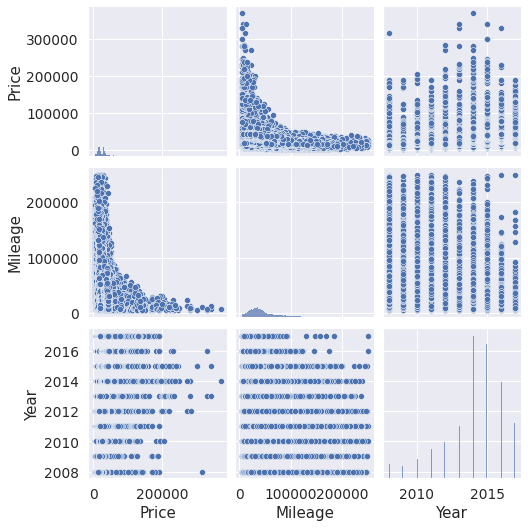

In [33]:
# Scatter plot for numerical features
num_features = ["Price", "Mileage", "Year"]
sns.pairplot(cleaned_cars[num_features], size = 2.5)
plt.show();

# In the Mileage/Price plot we observe that the lesser is the mileage, the higher
# is the price. In the Year/Price plot instead, we observe that the prices
# are somewhat equally distributed between the various years.

In [34]:
cleaned_cars.sample(5)

,Price,Year,Mileage,Make,Model
587424,13788,2013,65994,Toyota,PriusTwo
582655,14390,2014,28708,Toyota,CamryL
706204,26999,2012,105460,INFINITI,QX564WD
221067,27795,2010,52658,Ford,F-1504WD
420783,13980,2010,77035,Lincoln,MKXAWD


### TOWARDS NORMAL DISTRIBUTION OF PRICES


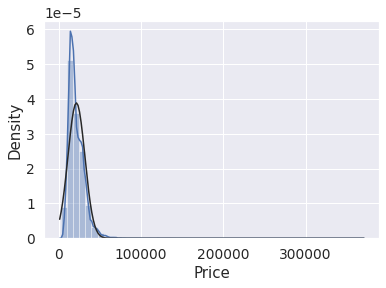

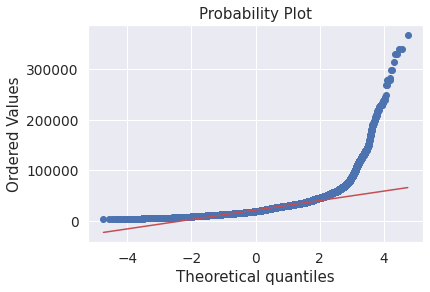

In [35]:
# Distribution of prices
from scipy.stats import norm
from scipy import stats

# Using Histogram and normal probability plot
sns.distplot(cleaned_cars['Price'], fit=norm);
fig = plt.figure()
res = stats.probplot(cleaned_cars['Price'], plot=plt)

In [36]:
#applying log transformation
cleaned_cars['Price'] = np.log(cleaned_cars['Price'])

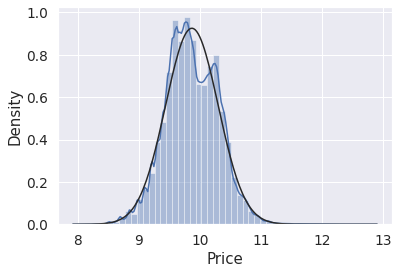

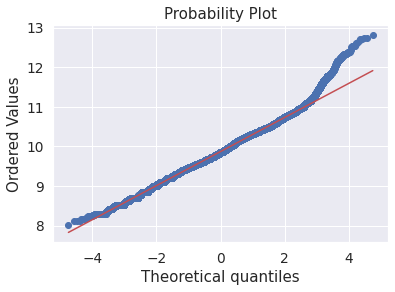

In [37]:
#transformed histogram and normal probability plot
sns.distplot(cleaned_cars['Price'], fit=norm);
fig = plt.figure()
res = stats.probplot(cleaned_cars['Price'], plot=plt)

### LABEL ENCODING

In [38]:
# LABEL ENCODING
features = ['Make', 'Model']
les = {}

for f in features:
  les[f] = preprocessing.LabelEncoder()
  les[f] = les[f].fit(cleaned_cars[f])
  cleaned_cars[f] = les[f].transform(cleaned_cars[f])

### TRAIN / TEST SPLIT

In [39]:
# Splitting the dataset into train and test sets
train_set, test_set = train_test_split(cleaned_cars, test_size = 0.33, random_state = 42)

"""
The Test Set in this case is our Hold-out set that we'll be using later
for final validation
"""

# Separating target labels from the rest
cars_train = train_set.drop("Price", axis=1) #train without target
cars_price_train = train_set["Price"].copy() #target

cars_test  = test_set.drop("Price", axis=1)
cars_price_test = test_set["Price"].copy()


## **TRAINING AND COMPARING MODELS**

**BEST SCORE FUNCTION**

In [40]:
# This function returns the best score achieved by the model over all the cv splits
def best_score(forest, cv):
  best_score = 0
  for i in range(0, cv):
    items = list(map(lambda x: abs(x), forest.cv_results_['split'+str(i)+'_test_score']))
    arr = np.append(best_score, items)
    best_score = max(arr)
  
  return best_score

**BEST PARAMS FUNCTION**

In [41]:
# This functions returns the best combination of parameters, which allows to
# get the best score
def best_params(forest):
  return forest.cv_results_['params'][forest.cv_results_['rank_test_score'][0]-1]

** PERFORMANCE METRIC FUNCTION **

In [42]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true (y_true) and predicted (y_predict) values based on the metric chosen. """
    
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### **LINEAR REGRESSION **

In [43]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

import os

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet

class DFSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.feature_names].values

In [44]:
# Setting categorical and numerical attributes
cat_features = ["Make", "Model"]
num_features = list(cars_train.drop(cat_features, axis=1))

# Building the Pipelines for categorical and numerical dataframes
numerical_pipeline = Pipeline([
    ("selector", DFSelector(num_features)),
    ("std_scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("selector", DFSelector(cat_features)),
    ("encoder", OneHotEncoder(sparse=True))
])

# full_pipeline
full_pipeline = FeatureUnion(transformer_list =[
    ("num_pipeline", numerical_pipeline),
    ("cat_pipeline", categorical_pipeline)
])


In [45]:
# Apply the full pipeline
ohe_cars_train = full_pipeline.fit_transform(cars_train) # train set

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/data.py:1961: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = check_array(X, dtype=np.int)


In [46]:
from sklearn.linear_model import LinearRegression

sc = createLocalSparkSession().sparkContext

model = LinearRegression()
parameters = {'fit_intercept':[False], 'normalize':[True,False], 'copy_X':[True, False]}

# Spark parallelized GridSearchCV for hyperparameter tuning
gs = GridSearchCV(sc, estimator=model, param_grid=parameters, cv=3, n_jobs=-1, verbose=1, return_train_score=True)
lin_reg = gs.fit(ohe_cars_train, cars_price_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [ ]:
# Best CV parameters
bp = best_params(lin_reg)
best_params(lin_reg)

lin_reg_model = LinearRegression(
                              fit_intercept=bp["fit_intercept"],
                              normalize=bp["normalize"],
                              copy_X=bp["copy_X"])
%time lin_reg_model.fit(ohe_cars_train, cars_price_train)

In [ ]:
# LinearRegression score for price prediction
ohe_cars_test = full_pipeline.transform(cars_test)

print("Best Linear Regression parameters:")
print(bp)
print("\nLinear Regressor score without CV on train set: %.3f" % lin_reg_model.score(ohe_cars_train, cars_price_train)) #score on train set
print("Linear Regression score without CV on test set: %.3f" % lin_reg_model.score(ohe_cars_test, cars_price_test)) # score on test set
print("Linear Regression Best score with CV=3: %.3f" % best_score(lin_reg, 3)) # -> best score on test set is high

In [ ]:
# Prediction on whole training set
from sklearn.metrics import mean_squared_error

price_predictions_train = lin_reg_model.predict(ohe_cars_train) #using the whole training set for making prediction with the final model given by the best CV parameters

# Reversing np.log operation
price_predictions_train_normal = np.exp(price_predictions_train)
cars_price_train_normal = np.exp(cars_price_train)

# MSE between target values (i.e known) and predicted values
lin_mse = mean_squared_error(cars_price_train_normal, price_predictions_train_normal)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

In [ ]:
print(price_predictions_train_normal[580:590])
print('\n')
print(list(cars_price_train_normal[580:590]))

In [ ]:
# Prediction on test set
price_predictions_test = lin_reg_model.predict(ohe_cars_test)

# Reversing np.log operation
price_predictions_test_normal = np.exp(price_predictions_test)
cars_price_test_normal = np.exp(cars_price_test)

final_mse = mean_squared_error(cars_price_test_normal, price_predictions_test_normal)
final_rmse = np.sqrt(final_mse)

final_rmse

In [ ]:
print(price_predictions_test_normal[7650:7660]) #predictions on test set
print('\n')
print(list(cars_price_test_normal[7650:7660])) #known values in test set

In [ ]:
from sklearn.metrics import r2_score
r2_score(cars_price_test_normal, price_predictions_test_normal, multioutput='variance_weighted') 

In [ ]:
# Plot predictions
plt.scatter(price_predictions_train_normal, np.exp(cars_price_train), c = "blue", marker = "s", label = "Training data")
plt.scatter(price_predictions_test_normal, np.exp(cars_price_test), c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([0, 350000], [0, 350000], c = "red")
plt.show()


In [ ]:
# Saving model for type prediction
pickle.dump(lin_reg_model, open("lin_reg_model_final.pkl", "wb"))

In [ ]:
# Loading the model for type prediction
lin_reg_model = pickle.load(open("lin_reg_model_final.pkl", 'rb'))

## **DECISION TREE REGRESSOR**

### LEARNING AND COMPLEXITY CURVES

In [ ]:
# Produce complexity curve for varying training set sizes and maximum depths
curves.ModelComplexity_DT(cars_train, cars_price_train)

In [ ]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer

def DT_SparkizedGridSearchCV(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 42)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':[1, 5, 10, 15, 16, 17]}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    sc = createLocalSparkSession().sparkContext
    grid = GridSearchCV(sc, estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    tree_reg = grid.fit(X, y)
    
    # Return grid search output after fittig the data
    return tree_reg

In [ ]:
from sklearn.model_selection import ShuffleSplit

# Fit the training data to the model using spark parallelized grid search CV
tree_reg = DT_SparkizedGridSearchCV(cars_train, cars_price_train)

# Takign best parameters
bp = best_params(tree_reg)

# Produce the optimal value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(bp['max_depth']))

In [ ]:
"""
Due to the limitation of the spark-sklearn library's implementation of
GridSearchCV, best_estimator_ parameter it's not available, so we need to
fit a DecisionTreeRegressor on the best parameters given to us by gridSearchCV
"""
tree_reg_model = DecisionTreeRegressor(
                              max_depth=bp['max_depth'])
%time tree_reg_model.fit(cars_train, cars_price_train)

In [ ]:
# DecisionTreeRegressor score for price prediction


print("Best Decision Tree Regressor parameters:")
print(bp)
print("\nDecision Tree Regressor score without CV on train set: %.3f" % tree_reg_model.score(cars_train, cars_price_train)) #score on train set
print("Decision Tree Regressor score without CV on test set: %.3f" % tree_reg_model.score(cars_test, cars_price_test)) # score on test set
print("Decision Tree Regressor Best score with CV=10: %.3f" % best_score(tree_reg, 10)) # -> best score on test set is high

In [ ]:
# Prediction on whole training set
price_predictions_train = tree_reg_model.predict(cars_train) #using the whole training set for making prediction with the final model given by the best CV parameters

# Reversing np.log operation
price_predictions_train_normal = np.exp(price_predictions_train)
cars_price_train_normal = np.exp(cars_price_train)

# MSE between target values (i.e known) and predicted values
lin_mse = mean_squared_error(cars_price_train_normal, price_predictions_train_normal)
lin_rmse = np.sqrt(lin_mse)
lin_rmse # is higher than RMSE of linear regression, in fact the best score is smaller (0.58 vs 0.89)

In [ ]:
print(price_predictions_train_normal[1670:1680])
print('\n')
print(list(cars_price_train_normal[1670:1680]))

In [ ]:
# Prediction on test set
price_predictions_test = tree_reg_model.predict(cars_test)

# reversing np.log operation
price_predictions_test_normal = np.exp(price_predictions_test)
cars_price_test_normal = np.exp(cars_price_test)

final_mse = mean_squared_error(cars_price_test_normal, price_predictions_test_normal)
final_rmse = np.sqrt(final_mse)

final_rmse

In [ ]:
print(price_predictions_test_normal[1939:1949]) #predictions on test set
print('\n')
print(list(cars_price_test_normal[1939:1949])) #known values in test set

In [ ]:
from sklearn.metrics import r2_score
r2_score(cars_price_test_normal, price_predictions_test_normal, multioutput='variance_weighted') 

**PREDIZIONE PREZZO MACCHINA**

In [ ]:
model = les['Model'].transform(['Maxima3.5'])
brand = les['Make'].transform(['Nissan'])

year = 2016
mileage = 21000

car = [[ year, mileage, brand[0], model[0]]]

In [ ]:
predicted_price = tree_reg_model.predict(car)
print(np.exp(predicted_price))

In [ ]:
# Saving model for type prediction
pickle.dump(tree_reg_model, open("tree_reg_model_final.pkl", "wb"))

In [ ]:
# Loading the model for type prediction
tree_reg_model = pickle.load(open("tree_reg_model_final.pkl", 'rb'))

## **RANDOM FOREST REGRESSOR**

### LEARNING AND COMPLEXITY CURVES

In [ ]:
# Produce complexity curve for varying training set sizes and maximum depths
curves.ModelComplexity_RF(cars_train, cars_price_train)

### Model Training

In [ ]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

def RF_SparkizedGridSearchCV(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 42)

    # Create a decision tree regressor object
    regressor = RandomForestRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':[16, 17, 18]}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    sc = createLocalSparkSession().sparkContext
    grid = GridSearchCV(sc, estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    tree_reg = grid.fit(X, y)
    
    # Return the best parameters after fitting the data
    return tree_reg

In [ ]:
from sklearn.model_selection import ShuffleSplit

# Fit the training data to the model using spark parallelized grid search CV
forest_reg = RF_SparkizedGridSearchCV(cars_train, cars_price_train)

# Takign best parameters
bp = best_params(forest_reg)

# Produce the optimal value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(bp['max_depth']))

In [ ]:
# Fitting the forest

forest_reg_model = RandomForestRegressor(
                              max_depth=bp['max_depth']
                                 
)

%time forest_reg_model.fit(cars_train, cars_price_train)

In [ ]:
# RandomForestRegressor score for price prediction

print(bp)
print("\nRandom Forest Regressor score without CV on train set: %.3f" % forest_reg_model.score(cars_train, cars_price_train)) #score on train set
print("Random Forest Regressor score without CV on test set: %.3f" % forest_reg_model.score(cars_test, cars_price_test)) #score on test set
print("Random Forest Regressor Best score with CV=4: %.3f" % best_score(forest_reg, 4)) # -> best score on test set is high

In [ ]:
# Prediction on whole training set
price_predictions_train = forest_reg_model.predict(cars_train) #using the whole training set for making prediction with the final model given by the best CV parameters

# Reversing np.log operation
price_predictions_train_normal = np.exp(price_predictions_train)
cars_price_train_normal = np.exp(cars_price_train)

# MSE between target values (i.e known) and predicted values
lin_mse = mean_squared_error(cars_price_train_normal, price_predictions_train_normal)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

In [ ]:
print(price_predictions_train_normal[25670:25680])
print('\n')
print(list(cars_price_train_normal[25670:25680]))

In [ ]:
# Prediction on test set
price_predictions_test = forest_reg_model.predict(cars_test)

# Reversing np.log operation
price_predictions_test_normal = np.exp(price_predictions_test)
cars_price_test_normal = np.exp(cars_price_test)

final_mse = mean_squared_error(cars_price_test_normal, price_predictions_test_normal)
final_rmse = np.sqrt(final_mse)

final_rmse

In [ ]:
print(price_predictions_test_normal[1870:1880]) #predictions on test set
print('\n')
print(list(cars_price_test_normal[1870:1880])) #known values in test set

In [ ]:
# r2 score between hold out prices and predicted prices
r2_score(cars_price_test_normal, price_predictions_test_normal, multioutput='variance_weighted') 

In [ ]:
# Saving model for type prediction
pickle.dump(forest_reg_model, open("forest_reg_model_final.pkl", "wb"))

In [ ]:
# Loading the model for type prediction
forest_reg_model = pickle.load(open("forest_reg_model_final.pkl", 'rb'))

## **CROSS VALIDATION**

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

### LINEAR REGRESSION

In [ ]:
# Cross val score on training set, although we already used GridSearchCV 

train_scores = cross_val_score(lin_reg_model, ohe_cars_train, np.exp(cars_price_train),
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-train_scores)

display_scores(tree_rmse_scores)

In [ ]:
train_scores = cross_val_score(lin_reg_model, ohe_cars_train, np.exp(cars_price_train),
                          cv=10)

display_scores(train_scores)

### DECISION TREE

In [ ]:
# Cross val score on training set

train_scores = cross_val_score(tree_reg_model, cars_train, np.exp(cars_price_train),
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-train_scores)

display_scores(tree_rmse_scores)

In [ ]:
train_scores = cross_val_score(tree_reg_model, cars_train, np.exp(cars_price_train),
                          cv=10)

display_scores(train_scores)

###RANDOM FOREST

In [ ]:
from sklearn.model_selection import KFold

# Cross val score on training set, although we already used grid search CV
train_scores = cross_val_score(forest_reg_model, cars_train, np.exp(cars_price_train),
                         scoring="neg_mean_squared_error", cv=KFold(10, shuffle=True))
forest_rmse_scores = np.sqrt(-train_scores)

display_scores(forest_rmse_scores)

In [ ]:
train_scores = cross_val_score(forest_reg_model, cars_train, np.exp(cars_price_train),
                          cv=5)

display_scores(train_scores)

## **PREDICTIONS ON FINAL MODEL AND CONCLUSIONS**

In [ ]:
final_model = forest_reg_model

**FEATURE IMPORTANCE**

In [ ]:
# Feature importance computed with cross validation
from rfpimp import cv_importances, plot_importances
%time I = cv_importances(final_model, cars_train, np.exp(cars_price_train), k=5)
plot_importances(I)

In [ ]:
# Prediction on the hold out test set
final_predictions = final_model.predict(cars_test)

final_mse = mean_squared_error(np.exp(cars_price_test), np.exp(final_predictions))

final_rmse = np.sqrt(final_mse)

In [ ]:
print("Test RMSE: %f " % final_rmse)
print("Score on held-out Test Set: %f " % final_model.score(cars_test, cars_price_test))
print("R2 Score: %f" % r2_score(np.exp(cars_price_test), np.exp(final_predictions)))

In [ ]:
# Cross validation on the entire dataset, since we are good with out final model

features = cleaned_cars.drop(['Price'], axis=1)
prices = cleaned_cars['Price'].copy()

final_rmses= cross_val_score(final_model, features, np.exp(prices),
                          scoring="neg_mean_squared_error", cv=KFold(10, shuffle=True))

final_rmse_scores = np.sqrt(-final_rmses)
display_scores(final_rmse_scores)

In [ ]:
final_scores = cross_val_score(tree_reg_model, features, np.exp(prices),
                          cv=KFold(10, shuffle=True))

display_scores(final_scores)